# Part 1: Camera calibration (Intrinsic parameters)

In [56]:
import numpy as np
import cv2
import glob
import os

In [2]:
 # termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


In [4]:
images = glob.glob('./Chessboard/*.JPG')


In [5]:
print(images)

['./Chessboard/8.JPG', './Chessboard/9.JPG', './Chessboard/14.JPG', './Chessboard/13.JPG', './Chessboard/11.JPG', './Chessboard/10.JPG', './Chessboard/4.JPG', './Chessboard/5.JPG', './Chessboard/7.JPG', './Chessboard/6.JPG', './Chessboard/2.JPG', './Chessboard/3.JPG', './Chessboard/1.JPG']


In [65]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners,ret)
        name = fname.replace("./Chessboard/","")
        cv2.imwrite("./res/part 1/"+str(name),img)
        #print("./res/part 1/"+str(name)+".png")
        cv2.imshow('img',img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

./res/part 1/8.JPG.png
./res/part 1/9.JPG.png
./res/part 1/14.JPG.png
./res/part 1/13.JPG.png
./res/part 1/11.JPG.png
./res/part 1/10.JPG.png
./res/part 1/4.JPG.png
./res/part 1/5.JPG.png
./res/part 1/7.JPG.png
./res/part 1/6.JPG.png
./res/part 1/2.JPG.png
./res/part 1/3.JPG.png
./res/part 1/1.JPG.png


In [9]:
 ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [10]:
print(ret)


0.5589320351689552


In [11]:
print(mtx)

[[595.15497567   0.         276.05917364]
 [  0.         612.59466701 381.21361238]
 [  0.           0.           1.        ]]


In [12]:
principalPoint = (mtx[0][2],mtx[1][2])

In [13]:
focal = (mtx[0][0]+mtx[1][1])/2

In [14]:
print(principalPoint)

(276.0591736428194, 381.2136123810228)


# Part 2: Take the pictures

# Part 3: Compute the relative camera pose

In [15]:
from matplotlib import pyplot as plt

img1 = cv2.imread('./Pair image/myleft.JPG',0)  #queryimage # left image
img2 = cv2.imread('./Pair image/myright.JPG',0) #trainimage # right image


In [16]:
cv2.imshow('img1',img1)
#cv2.waitKey(500)
cv2.destroyAllWindows()


In [17]:
import cv2
cv2.__version__

'3.3.0'

In [18]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

Got the list of best matches from both images

In [19]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [20]:
print(F)

[[-2.82168712e-08  3.30652500e-06 -2.39694082e-03]
 [-3.51126870e-06  1.16811814e-07  9.03981104e-03]
 [ 2.46799293e-03 -9.92541358e-03  1.00000000e+00]]


Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image. So mentioning of correct images are important here. We get an array of lines. So we define a new function to draw these lines on the images.

In [21]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

Now we find the epilines in both the images and draw them.

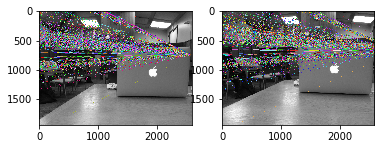

In [60]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
cv2.imwrite("./res/part 2/epilineleft.png", img5)
cv2.imwrite("./res/part 2/epilineright.png", img3)
plt.show()
cv2.destroyAllWindows()

Compute the essential matrix E
https://docs.opencv.org/3.1.0/d9/d0c/group__calib3d.html#ga13f7e34de8fa516a686a56af1196247f

In [23]:
E, mask = cv2.findEssentialMat(pts1, pts2, focal, principalPoint, method=cv2.RANSAC, prob=0.999, threshold=3.0)

In [24]:
print(E)

[[-0.00328385  0.04070008  0.06617857]
 [-0.06314851  0.00880867  0.70104931]
 [-0.04805229 -0.70430074  0.00831244]]


In [25]:
R1,R2,t = cv2.decomposeEssentialMat(E)

### decompose the essential matrix, we got two rotaion matrixs, R1(3*3) and R2(3*3), and one translation vector (3*1).
### We need the  projection matrix of the first camera and projection matrix of the second camera to calculate the triangulatePoints
### projMatr1 – 3x4 projection matrix of the first camera.
### projMatr2 – 3x4 projection matrix of the second camera.

In [26]:
print(R1)

[[ 0.99909091  0.02709379  0.03291312]
 [-0.02661309  0.99953392 -0.01495636]
 [-0.03330301  0.01406684  0.9993463 ]]


In [27]:
print(R2)

[[ 0.97620017 -0.15974222  0.14668214]
 [-0.16117865 -0.98692298 -0.00211784]
 [ 0.14510229 -0.0215746  -0.98918141]]


In [28]:
print(t)

[[ 0.99393472]
 [-0.09449379]
 [ 0.0562556 ]]


### There are 4 possible combination for the projection matrix.
#### Case 1:  projMatr1 = K [ I 0]   projMatr2 = K[R1 t]
#### Case 2:  projMatr1 = K[ I 0]   projMatr2 = K[R1  -t]
#### Case 3:  projMatr1 = K[ I 0]   projMatr2 = K[R2 t]
#### Case 4:  projMatr1 = K[ I 0]   projMatr2 = K[R2 -t]


In [29]:
points1 = np.array(pts1).astype(float).T 
points2 = np.array(pts2).astype(float).T

In [30]:
# make a projection matrix for camera 1
projMatr1 = mtx@np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

In [31]:
# case 1
projMatr21 = mtx@np.concatenate((R1,t),1)
# case 2
projMatr22 = mtx@np.concatenate((R1,-t),1)
# case 3
projMatr23 = mtx@np.concatenate((R2,t),1)
# case 4
projMatr24 = mtx@np.concatenate((R2,-t),1)

In [32]:
triangulate1 = cv2.triangulatePoints(projMatr1, projMatr21,points1,points2)
triangulate2 = cv2.triangulatePoints(projMatr1, projMatr22,points1,points2)
triangulate3 = cv2.triangulatePoints(projMatr1, projMatr23,points1,points2)
triangulate4 = cv2.triangulatePoints(projMatr1, projMatr24,points1,points2)

In [33]:
print(triangulate1.T)

[[ 0.8330936  -0.22325353  0.4753981   0.17352109]
 [ 0.84089189 -0.2084152   0.46993469  0.1691902 ]
 [ 0.8519197  -0.20137944  0.45639298  0.15932542]
 ...
 [-0.37486076 -0.29848006 -0.78813581 -0.3863043 ]
 [ 0.63612354  0.14796643  0.68972207  0.31262795]
 [-0.66248355  0.18788379 -0.66264039 -0.2944876 ]]


#### case 1 got negtive distance, get rid of it.

In [34]:
print(triangulate2.T)

[[ 0.8330936  -0.22325353  0.4753981  -0.17352109]
 [ 0.84089189 -0.2084152   0.46993469 -0.1691902 ]
 [ 0.8519197  -0.20137944  0.45639298 -0.15932542]
 ...
 [-0.37486076 -0.29848006 -0.78813581  0.3863043 ]
 [-0.63612354 -0.14796643 -0.68972207  0.31262795]
 [-0.66248355  0.18788379 -0.66264039  0.2944876 ]]


#### case 2 got negtive distance, get rid of it.

In [35]:
print(triangulate3.T)

[[-0.38215408  0.10241015 -0.21807313  0.89214042]
 [-0.38438109  0.09526891 -0.21481242  0.89276572]
 [-0.38791879  0.09169746 -0.20781702  0.89326518]
 ...
 [-0.24333718 -0.19375307 -0.51160576  0.80094089]
 [-0.32935496 -0.07661005 -0.35710571  0.8707076 ]
 [-0.33139171  0.09398413 -0.33146957  0.87833618]]


#### case 3 got negtive distance, so I get rit of this case.

In [36]:
print(triangulate4.T)

[[ 0.38215408 -0.10241015  0.21807313  0.89214042]
 [ 0.38438109 -0.09526891  0.21481242  0.89276572]
 [ 0.38791879 -0.09169746  0.20781702  0.89326518]
 ...
 [ 0.24333718  0.19375307  0.51160576  0.80094089]
 [ 0.32935496  0.07661005  0.35710571  0.8707076 ]
 [ 0.33139171 -0.09398413  0.33146957  0.87833618]]


#### case 4 has the positive distance , so the (R2,-t) is the right R and t

In [37]:
triangulate4.T

array([[ 0.38215408, -0.10241015,  0.21807313,  0.89214042],
       [ 0.38438109, -0.09526891,  0.21481242,  0.89276572],
       [ 0.38791879, -0.09169746,  0.20781702,  0.89326518],
       ...,
       [ 0.24333718,  0.19375307,  0.51160576,  0.80094089],
       [ 0.32935496,  0.07661005,  0.35710571,  0.8707076 ],
       [ 0.33139171, -0.09398413,  0.33146957,  0.87833618]])

In [38]:
triangulate4world = np.true_divide(triangulate4.T[:,:3], triangulate4.T[:,[-1]]).T

In [39]:
print(triangulate4world.T)

[[ 0.42835642 -0.11479152  0.24443813]
 [ 0.43055091 -0.10671211  0.24061455]
 [ 0.43427058 -0.10265424  0.23264874]
 ...
 [ 0.30381416  0.24190683  0.63875596]
 [ 0.37826127  0.08798597  0.41013277]
 [ 0.37729484 -0.10700246  0.37738348]]


In [40]:
print(triangulate4world.shape)

(3, 828)


In [41]:
pixelh = mtx@triangulate4world

In [42]:
print(pixelh.T)

[[3.22417842e+02 2.28624708e+01 2.44438129e-01]
 [3.22668368e+02 2.63542705e+01 2.40614546e-01]
 [3.22683117e+02 2.58034279e+01 2.32648742e-01]
 ...
 [3.57150948e+02 3.91693298e+02 6.38755957e-01]
 [3.38344991e+02 2.10247930e+02 4.10132766e-01]
 [3.28729072e+02 7.83145830e+01 3.77383482e-01]]


In [43]:
pixel = np.true_divide(pixelh.T[:,:2],pixelh.T[:,[-1]])

In [44]:
print(points1.T)

[[1319.   93.]
 [1341.  109.]
 [1387.  111.]
 ...
 [ 559.  612.]
 [ 825.  513.]
 [ 871.  206.]]


In [45]:
print(pixel)

[[1319.01615953   93.5307064 ]
 [1341.01771139  109.52899962]
 [1386.99704198  110.91153005]
 ...
 [ 559.13521313  613.21275131]
 [ 824.96454533  512.63382964]
 [ 871.07435249  207.51990149]]


In [46]:
print(pixel.shape)

(828, 2)


In [47]:
imgleft = cv2.imread('./Pair image/myleft.JPG')  #queryimage # left image
imgright = cv2.imread('./Pair image/myright.JPG') #trainimage # right image



In [48]:
cv2.imshow('left',imgleft)

In [57]:
for point in pixel.astype(int):
    #print(tuple(point))
    
    imgleft = cv2.circle(imgleft,tuple(point),10,(0, 0, 200),-1)
for point in points1.T.astype(int):
    #print(tuple(point))
    imgleft = cv2.circle(imgleft,tuple(point),5,(200, 0, 0),-1)
cv2.imwrite("./res/part 3/reporject.png", imgleft)
#plt.imshow(imgleft)
#cv2.imshow('left',imgleft )
#cv2.waitKey(0)
#cv2.destroyAllWindows()


True

# Part 4: Plane-sweeping stereo

### 4.1 compute 20 depth to generate a array of 20 depth

In [ ]:
dmin = 

In [ ]:
ddepth = (dmax - dmin)/19